# 6-1. 들어가며

## 학습 목표
---
- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

## 학습 전제
---
- 정형 데이터를 활용해 EDA와 간단한 분류, 회귀 문제를 해결해본 적이 있다.
- numpy, pandas, matplotlib을 활용해 정형 데이터를 자유자재로 다룰 수 있다.
- 정형 데이터를 활용해 다양한 모델을 학습시켜보고, 예측 결과를 도출하는 것까지의 과정을 코드로 진행할 수 있다.

## 목차
---
1. 대회의 시작: 참가 규칙과 데이터, 평가 기준 살펴보기
2. 자 그럼, 일단 제출하고 시작해! Baseline은 여기 있으니까!
3. 랭킹을 올리고 싶다면? 최적의 모델을 찾아서, 하이퍼 파라미터 튜닝
4. 프로젝트: This is your playground! Leaderboard를 정복해주세요!

# 준비물
---
이번 노드에서는 회귀 모델을 구현하는 데에 사용하는 xgboost와 lightgbm 라이브러리와, 결측 데이터를 확인하는 missingno 라이브러리가 필요합니다.

클라우드 커널 사용시에는 이미 필요한 라이브러리가 설치되어있기 때문에 따로 설치하지 않고 실습을 위한 디렉토리만 생성해 주면 됩니다.

Cloud shell에서 아래 명령어를 입력해주세요.

라이브러리가 잘 설치되어있는지 아래 명령어로 확인 할 수 있습니다.

- conda list | grep xgboost
- conda list | grep lightgbm
- conda list | grep missingno
- pip list | grep scikit-learn

- mkdir -p ~/aiffel/kaggle_kakr_housing

In [18]:
# 필요한 라이브러리 import 하기

import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

print('done')

done


In [19]:
# 데이터 경로 지정하기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


# 6-2. 대회의 시작 (1) 참가 규칙, 평가 기준 살펴보기

A. Description, 대회 소개
---
가입 및 로그인을 무사히 마치고 나면 아마 다음과 같은 첫 페이지를 보게 되실 겁니다.  
캐글에는 아주 다양한 경진대회들이 있고, 각 경진대회들은 모두 대회 소개, 데이터셋 소개, 규칙 설명 등 대회에 참가하는 사람들을 위한 세부 내용들로 구성되어 있습니다.  

당연히 대회별로 평가 방법과 규칙이 상이하니, 대회를 본격적으로 시작하기 전에 소개와 세부 내용을 잘 읽고 시작하는 것이 좋겠죠!  

이번 대회의 참여 방법을 보니 특별한 링크를 눌러야만 참여가 가능하다고 하네요.  
링크를 누르면 같은 페이지로 리디렉션 됩니다. 우리도 클릭해서 다시 한번 참가 페이지로 들어오겠습니다.

B. Evaluation, 점수 평가 기준
---
대회에서 각 참여자들의 점수를 어떤 기준으로 평가하는지도 매우 중요한 부분이죠.

왼쪽 탭에서 Evaluation을 누르면 평가 방식은 RMSE라고 합니다.
RMSE가 무엇인지 기억하시나요? 한번 기억을 더듬어 보시죠!

### Q1. RMSE는 무엇의 약자이며, 그 수식은 무엇인가? 어떤 의미를 가지고 있는가?

A1. RMSE는 Root Mean Squared Error 의 약자이며, 이는 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근입니다.

### Q2. 그렇다면 이번 대회에서 푸는 문제는 분류 문제일까요, 회귀 문제일까요?

A2. 어떤 카테고리에 속하는지를 맞추는 문제가 아니라, 실수값을 맞추는 문제이므로 회귀 문제입니다.

C. Prize, 상품
---
이번 대회에는 상품도 있었나 보군요!

상위 리더보드 100명, 즉 100등까지 상품을 주는데, 조건이 특이합니다.
대회가 마무리된 후 사용한 소스코드를 커널 항목에 공개해야 하는 의무가 있다고 하네요. 지식의 "공유"와 "공개"를 지향하는 캐글의 정신을 본따 정해진 규칙이라고 합니다.

아쉽지만 대회는 이미 다 끝났기 때문에 우리는 상품을 받지 못합니다.

하지만 이번 것을 연습 삼아 실제 지금 진행되고 있는 대회를 참가하면 우리도 상품 또는 상금을 받을 수도 있겠죠!

D. Timeline, 대회 일정
---
실제 대회를 나간다면 대회 일정을 숙지하는 것도 중요합니다.
상금을 노리고 있다면 대회의 공식 마감일 전에 여러 실험을 통해 성능을 끌어올려야겠죠!

E. Rules, 대회 규칙
---
다음은 대회의 규칙입니다.

많은 사람이 참가하고, 또 상품이 걸려있는 만큼 엄격한 규칙들이 있을 수 있습니다.
부정행위를 통해 얻은 점수는 무효가 될 뿐만 아니라 향후 캐글의 다른 대회에 참가하는 것에도 불이익이 있을 수 있다는 점, 잊지 마세요.

# 6-3. 대회의 시작 (2) 데이터 살펴보기

F. Data Description, 데이터 설명
---
다음은 데이터에 대한 설명입니다.

복잡한 데이터를 다루는 대회일수록, 데이터의 설명을 굉장히 꼼꼼하게 읽는 것도 중요합니다.
데이터를 잘 이해할수록, 더 좋은 결과를 낼 수 있을 테니까요!

다양한 컬럼들을 가지고 있는 데이터이군요. 우리가 예측해야 하는 컬럼은 price, 즉 집의 가격입니다.

G. Data Explorer, 데이터 파일
---
데이터셋 자체에 대한 설명 외에도, 우리가 다운받아야 할 데이터 파일에 대한 형태를 살펴봐야 합니다.

이 대회에서는 train.csv라는 모델 학습용 파일과, test.csv라는 테스트용 파일, 그리고 sample_submission.csv라는 제출용 파일이 제공됩니다.

우리는 train.csv를 활용해서 데이터를 뜯어보고 모델을 학습시킨 후, test.csv 파일의 데이터에 대해 price를 예측해서 sample_submission.csv의 형식에 맞는 형태로 캐글에 제출을 해볼 것입니다.

원래라면 위 화면에서 Download 버튼을 누르시면 데이터를 다운 받으실 수 있지만 이번 대회에서는 데이터가 중간에 한 번 변경되었다고 합니다. 따라서 저희가 준비한 파일을 사용하시면 됩니다.

아래가 저희가 사용할 파일인데 참고용으로만 봐주세요. 클릭하지 않으셔도 진행하실 수 있습니다.

kaggle-kakr-housing-data.zip
데이터 다운로드 없이 Cloud shell에서 아래 명령어를 입력해주세요.

- mkdir -p ~/aiffel/kaggle_kakr_housing/data
- ln -s ~/data/data/*.csv ~/aiffel/kaggle_kakr_housing/data
- ls ~/aiffel/kaggle_kakr_housing/data  # 디렉토리 내 파일 확인

# 6-4. 일단 제출하고 시작해! Baseline 모델 (1) Baseline 셋팅하기

이번 대회에서는 주최자 차원에서 Baseline을 제공하였습니다. Baseline이라 함은 기본적으로 문제 해결을 시작할 때 쉽게 사용해볼 수 있는 샘플을 이야기하죠.

보통 대회에서 Baseline은 제공이 되는 경우도, 아닌 경우도 있는데 이번 대회는 특히 교육적인 성격도 있어서 제공이 되었던 것 같습니다.
우리도 있는 것을 안 써먹을 이유는 없으니, Baseline으로 빠르게 제출해보도록 하겠습니다!

Baseline 커널은 다음 링크에 있는데요. 한번 이동해봅시다.

다른 사람의 커널을 ipynb 파일로 다운받아 사용하기
---
캐글의 커널(Kernel) 은 우리가 쓰는 주피터 노트북 형태의 파일이 캐글 서버에서 실행될 때 그 프로그램을 일컫는 개념입니다.

우리도 캐글 자체의 서버에서 baseline 노트북 파일을 돌리고 모델 학습을 시킬 수도 있는데요, 그러기 위해 아래와 같이 보이는 화면에서 Copy and Edit 버튼을 클릭해보겠습니다.

Copy and Edit 버튼을 클릭했다면 다음과 같은 웹상에서 코드를 돌려볼 수 있는 커널 창이 뜹니다.

이렇게 커널 창 위에서 그대로 진행해도 되지만, 우리는 노트북 파일을 다운로드하여 사용해보겠습니다.
아래처럼 File > Download 를 통해 커널을 ipynb 파일로 다운받아 주세요!

Baseline 커널 파일 실행 준비
---
Baseline 노트북 파일을 다운받았으니 우리가 직접 돌려보고 점수까지 내보아야겠죠.  
다만 Baseline의 모든 코드를 에러없이 잘 돌리기 위해서는 몇 가지 준비가 필요합니다.

## ✓ 데이터 파일을 현재 디렉토리로 옮기기

먼저, 당연히 데이터를 노트북 파일과 같은 폴더 내에 두어야겠죠.
혹시 다른 위치에 압축을 해제하셨다면, 모델 학습 및 예측에 필요한 파일이 들어있는 데이터 폴더를 아래와 같은 형태로 노트북과 같은 위치로 옮겨주세요.

클라우드 커널 사용시 본 화면 우측 하단에 있는 버튼들 중, 위에서 두 번째의 Cloud Jupyter 환경을 열어주세요.
aiffel, kaggle_kakr_housing 디렉토리 순으로 이동하여 Cloud Jupyter 화면 우측 상단의 Upload 버튼을 눌러, 캐글에서 다운 받으셨던 2019-ml-month-2nd-baseline.ipynb 파일을 업로드 해주세요.

💡 ~/aiffel/kaggle_kakr_housing 폴더를 활용하세요!

### ✓ 필요한 라이브러리 설치하기
다음은 Baseline이 사용하는 몇 가지 라이브러리를 설치하는 법을 알아보겠습니다.  

LMS 상에는 이미 설치돼있으니 참고만 해주세요! 앞서 "들어가며"에서도 말씀드렸지만,  

이번 노드에서는 회귀 모델을 구현하는 데에 사용하는 xgboost와 lightgbm 라이브러리와,  

결측 데이터를 확인하는 missingno 라이브러리가 필요합니다.  

- conda install -c conda-forge xgboost=1.3.3
- conda install -c conda-forge lightgbm=3.1.1 
- conda install -c conda-forge missingno=0.4.2

### ✓ Jupyter Notebook 파일 실행 후 matplotlib 시각화를 위해 다음 셀 실행하기

마지막으로, 위에서 다운받았던 2019-ml-month-2nd-baseline.ipynb 주피터 노트북 파일을 실행합니다.

혹은 앞서 말씀드린대로 LMS 상에서만 코드를 돌려보셔도 무방합니다.

Baseline 커널에는 다양한 시각화 코드가 있기 때문에 노트북의 맨 위에 아래의 코드를 실행시켜서 시각화 그래프가 나타날 수 있도록 합니다.

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 6-5. 일단 제출하고 시작해! Baseline 모델 (2) 라이브러리, 데이터 가져오기

이제부터는 실제 Baseline 커널에 있는 내용입니다.  
대다수의 코드는 Baseline 커널에 있는 그대로이고, 중간중간 필요한 부분에 한해 부가설명을 추가하였습니다.

### ✓ 필요한 라이브러리 import 하기
전체 코드를 실행시키는 데에 필요한 모든 라이브러리를 한 번에 가져오는군요.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

print('얍💢')

얍💢


### ✓ 데이터 경로 지정하기
그다음은 데이터의 경로를 지정합니다. 여기서 잠깐, 주의해야 할 점은 우리의 파일 경로는 Baseline 커널과 다르다는 점입니다.  

Baseline 커널은 위에서 말했던 캐글의 서버에서 돌아가도록 코드가 설계되었기 때문에 데이터가 아래와 같이 ../input 이라는 디렉토리에 위치합니다.

1) Baseline 커널의 기존 코드

train_data_path = join('../input', 'train.csv')
sub_data_path = join('../input', 'test.csv')

하지만 우리는 프로젝트 디렉토리(~/aiffel/kaggle_kakr_housing 등) 내 data 폴더에 있는 파일을 사용하기로 했으므로 다음과 같이 바꾸겠습니다.

In [2]:
# 2) LMS에서 사용할 때 알맞은 파일 경로

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


# 6-6. 일단 제출하고 시작해! Baseline 모델 (3) 데이터 이해하기

### ✓ 데이터 살펴보기
Baseline 노트북은 먼저 아래와 같이 데이터를 살펴보고 있네요. 각 변수들이 나타내는 의미를 읽어 보겠습니다.

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

집에 대한 다양한 정보가 들어있는 것으로 보입니다. 이들의 특징을 활용해서 집의 가격을 맞추어야 하겠죠.

### ✓ 데이터 불러오기
데이터를 data, sub이라는 변수로 불러옵니다.

In [3]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


학습 데이터는 약 1만 5천 개, 테스트 데이터는 약 6천 개로 이루어져 있군요.
테스트 데이터는 물론 우리가 맞추어야 할 집의 가격, price가 없기 때문에 컬럼이 하나 적습니다.

### ✓ 학습 데이터에서 라벨 제거하기
price 컬럼은 따로 y라는 변수에 저장한 후 해당 컬럼은 지워줍니다.

- w3schools - python del keyword
- 참고로 데이터 분석 과정에서 칼럼을 없애고 싶다면 pandas.DataFrame.drop도 사용할 수 있습니다.

In [4]:
y = data['price']
del data['price']

print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


### ✓ 학습 데이터와 테스트 데이터 합치기
모델을 학습시키기 전에, 전체 데이터에 대해 탐색해보기 위해 두 데이터를 pd.concat으로 합쳐봅니다.

물론, 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용합니다.

In [5]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [6]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### ✓ 간단한 전처리
빈 데이터와 전체 데이터의 분포를 확인하는 전처리 작업입니다.  
결측치, 즉 빈 데이터가 있는지는 위에서 설치했던 missingno 라이브러리를 사용해서 확인하는군요.

원본 노트북에서는 다음과 같이 설명합니다.

각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.  
먼저 데이터에 결측치가 있는지를 확인하겠습니다.  
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

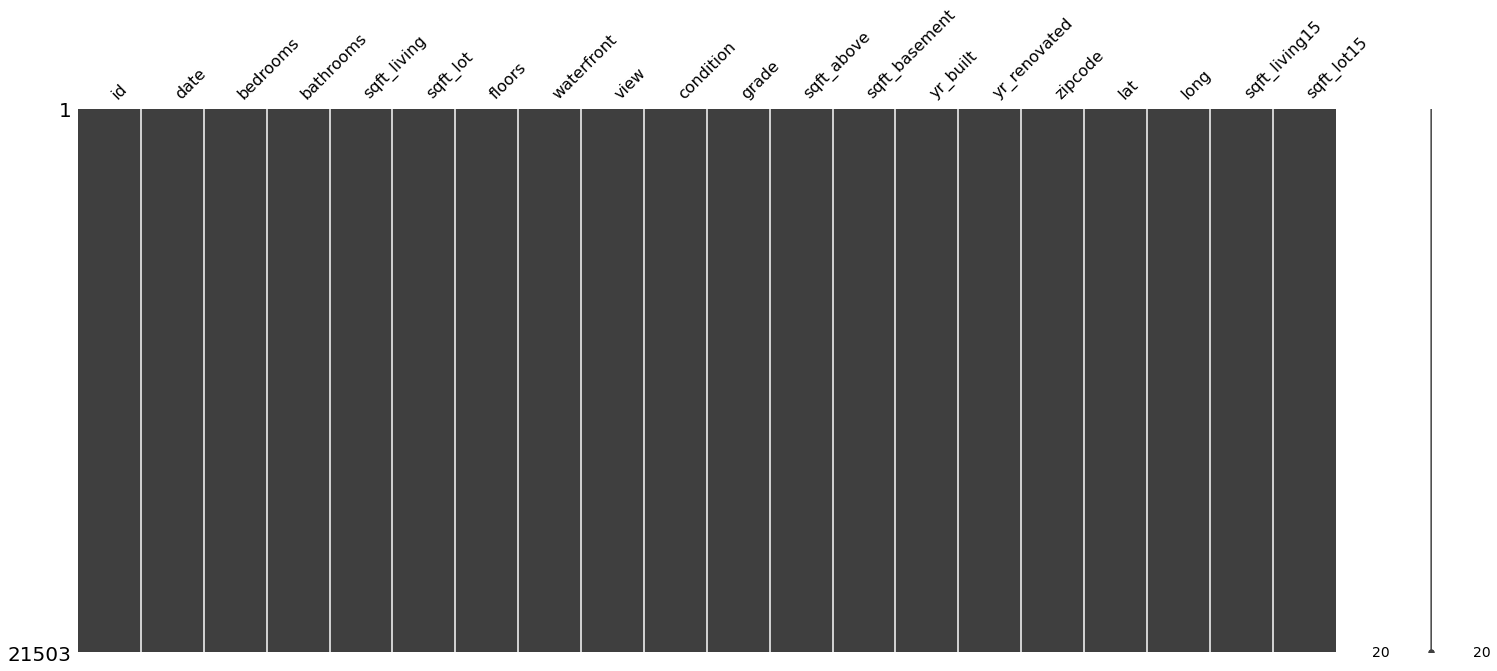

In [7]:
msno.matrix(data)

위에 출력된 것은 data라는 DataFrame을 매트릭스 모양 그대로 시각화한 것입니다.  
만약 특정 row, col에 NaN이라는 결측치가 있었다면 해당 부분이 하얗게 나옵니다.  
결측치가 없다면 매트릭스 전체가 까맣게 나올 겁니다. 실제로 그렇게 나왔나요??  

아래와 같이 직접 결측치의 개수를 출력해서 확인할 수도 있습니다.

- 데이터프레임 고급 인덱싱
우선 id를 가지고 데이터프레임 인덱싱을 적용해 사용법을 익혀봅시다.

천천히 진행하면 3단계를 거칩니다.

1. id컬럼이 결측치인지 확인합니다.
2. 결측치인 데이터만 뽑아냅니다.
3. 결측치인 데이터의 개수를 셉니다.

In [8]:
# 1. id 컬럼이 결측치인지 확인합니다.
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


무엇이 출력되나요?! True와 False로 이루어진 데이터프레임이 출력된다는 점에 주목하세요!

이 다음에 이루어지는 것이 인덱싱입니다. 데이터프레임을 이용해서 데이터프레임으로부터 원하는 값을 가져오는 아주 훌륭한 기능입니다!

In [9]:
# 2. 결측치인 데이터만 뽑아냅니다.
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

어떤가요? 결측치가 없기 때문에 빈 데이터프레임이 나왔네요.

인덱싱을 이용하면 데이터프레임을 그대로 사용할 수 있다는 것이 매우 큰 장점이에요. 인덱싱 기능이 없었더라면 항상 데이터프레임을 배열로 바꾸고 for문을 사용해야 했을겁니다. 게다가 인덱싱 기능이 속도면에서도 월등히 빠릅니다.

In [10]:
# 3. 결측치인 데이터의 개수를 셉니다.
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [11]:
# 한 번에 뿅!
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


In [12]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### ✓ id, date 변수 정리
필요 없는 id 컬럼을 제거합니다. 나중에 예측 결과를 제출할 때를 대비하여 sub_id 변수에 id 칼럼을 저장해두고 지우도록 하겠습니다.

In [13]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date 컬럼은 apply 함수로 필요한 부분만 잘라줍니다.

In [14]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


특히, 여기에서 str(x[:6]) 으로 처리한 것은 20141013T000000 형식의 데이터를 연/월 데이터만 사용하기 위해 201410까지 자르기 위한 것입니다.

### ✓ 각 변수들의 분포 확인
전체 데이터들의 분포를 확인합니다.  
특히 너무 치우친 분포를 가지는 컬럼의 경우 모델이 결과를 예측하는 데에 좋지 않은 영향을 미치므로 다듬는 작업을 합니다.  

아래 시각화 코드를 통해 id 컬럼을 제외한 19개 컬럼에 대해 한 번에 모든 그래프를 그려줍니다.  
10행 2열의 subplot에 그래프를 그리기 위해 2중 for문을 사용하고 있군요.  

그래프의 종류는 sns.kdeplot을 사용합니다.  
kdeplot은 이산(discrete) 데이터의 경우에도 부드러운 곡선으로 전체 분포를 확인할 수 있도록 하는 시각화 함수입니다.  

- seaborn.kdeplot
우리도 아래 코드로 전체 그래프를 그려보죠. 코드 실행 완료 후에도 실제 그래프가 나타나기까지 몇 초 정도 소요될 수 있습니다.

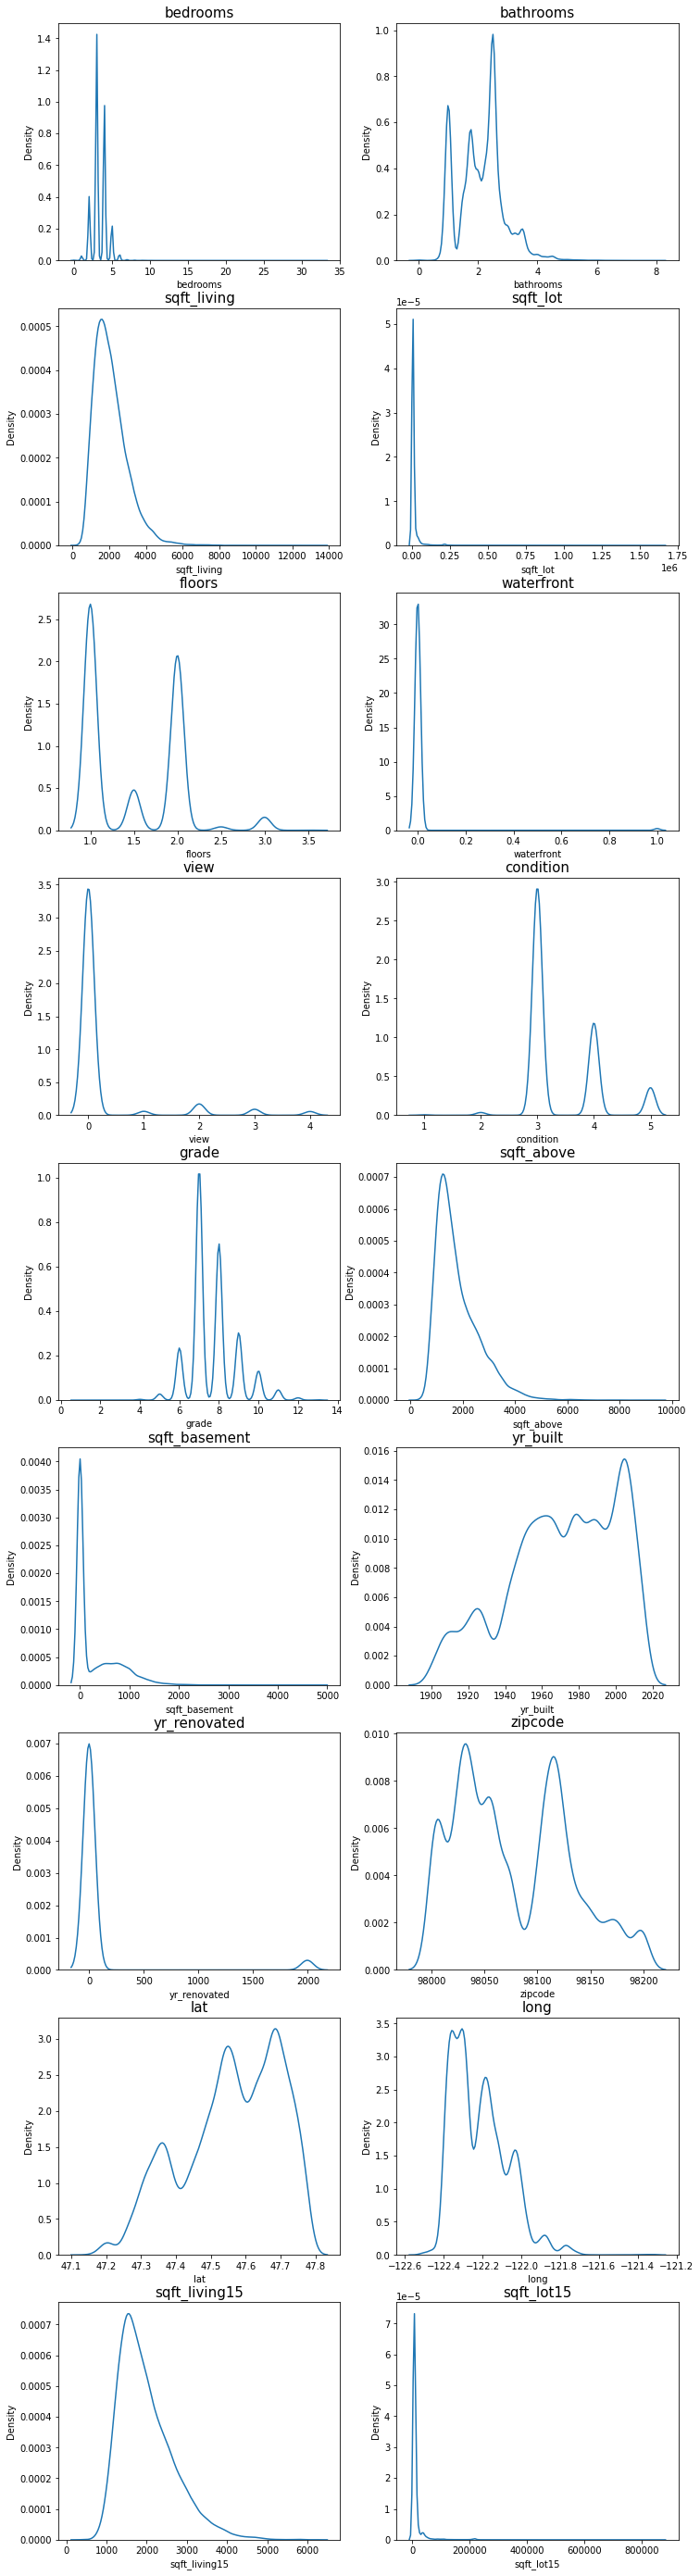

In [15]:
# 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

그래프의 분포를 보면 어떤 처리를 해주면 좋을지 떠올릴 수 있습니다.  

위 그래프 중에서는 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보이는군요.  

이렇게 한 쪽으로 치우친 분포의 경우에는 로그 변환(log-scaling)을 통해 데이터 분포를 정규분포에 가깝게 만들 수 있습니다. 자세한 이유는 아래에서 다시 다루고, 우선 결과부터 살펴봅시다.  

아래와 같이 치우친 컬럼들을 skew_columns 리스트 안에 담고, 모두 np.log1p()를 활용해서 로그 변환을 해주도록 하겠습니다.

numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.  

In [16]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

for c in skew_columns:
    data[c] = np.log1p(data[c].values) # numpy.log1p() 함수는 입력 배열의 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수입니다.  

print('얍💢')

얍💢


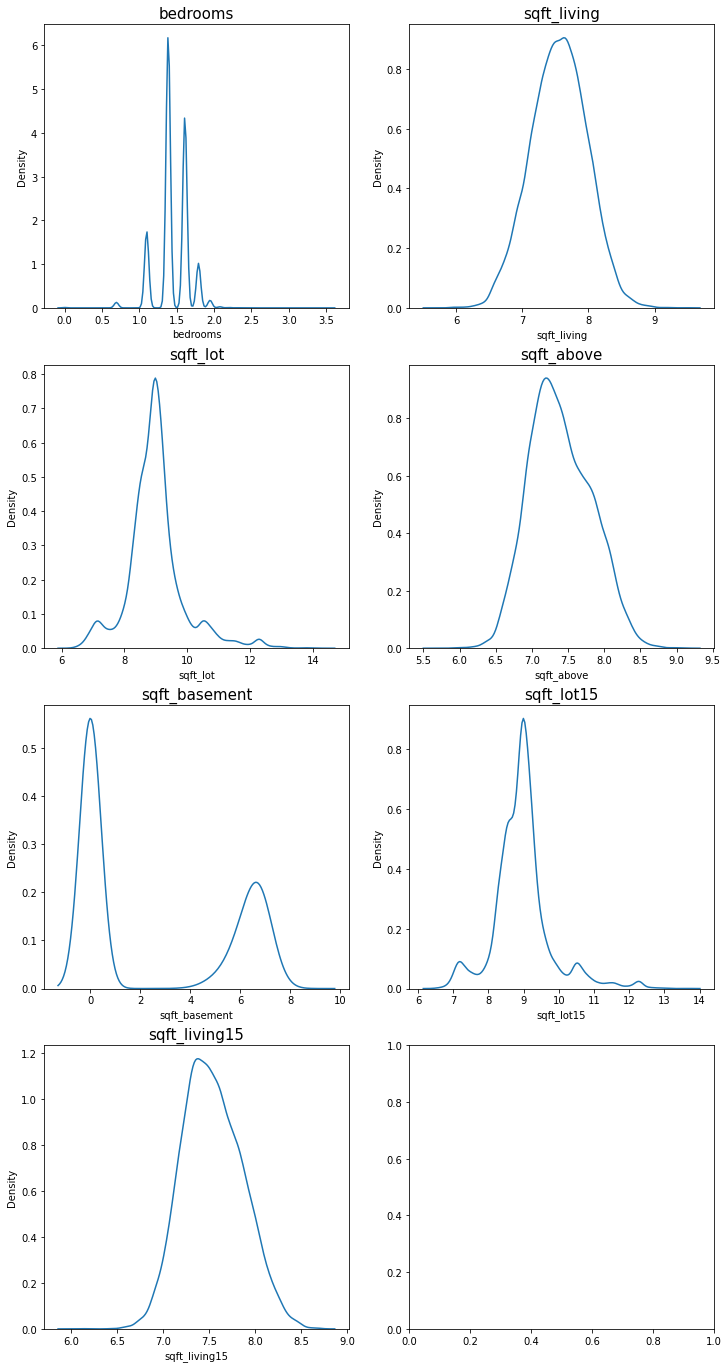

In [17]:
fig, ax = plt.subplots(4, 2, figsize=(12, 24))

count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

#### 그렇다면 왜 로그 변환은 분포의 치우침을 줄어들게 만드는 걸까요?
이는 로그 함수의 형태를 보면 알 수 있습니다. 아래의 일반적인 로그 함수를 살펴봅시다.

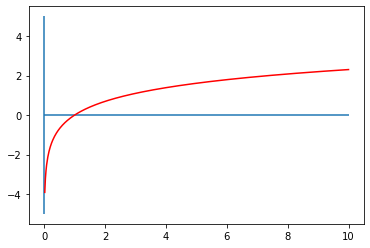

In [18]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

위와 같은 로그 함수의 특징은 다음과 같습니다.

- 0 < x < 10<x<1 범위에서는 기울기가 매우 가파릅니다. 즉, xx의 구간은 (0, 1)(0,1)로 매우 짧은 반면, yy의 구간은 (-\infty, 0)(−∞,0)으로 매우 큽니다.
- 따라서 0에 가깝게 모여있는 값들이 xx로 입력되면, 그 함수값인 yy 값들은 매우 큰 범위로 벌어지게 됩니다. 즉, 로그 함수는 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가집니다.
- 반면, xx값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아집니다. 이는 곧 큰 xx값들에 대해서는 yy값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 xx를 비교적 작은 yy값의 구간 내에 모이게 하는 특징을 가집니다.

위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있는 것이죠.

왜 한쪽으로 치우친 분포를 로그 변환을 취하게 되면 정규분포 모양으로 고르게 분포하게 될 수 있는지 이해가 되시나요?

그렇다면 우리가 맞추어야 할 타겟인 집의 가격, 즉 data[price]의 분포를 로그 변환했을 때 결과를 유추해봅시다.  
원래 price의 분포는 다음과 같습니다.

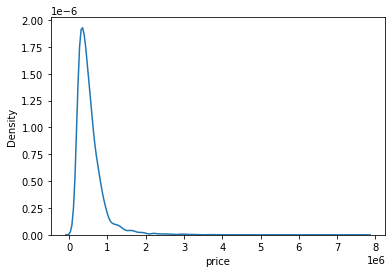

In [19]:
sns.kdeplot(y)
plt.show()

### Q3. 위 분포를 log 변환하게 되면 그 분포는 어떤 모양을 가지게 될까요?

- 위 분포는 0 쪽으로 매우 심하게 치우쳐져 있는 분포를 보입니다.
- 즉, 0과 1000000 사이에 대부분의 값들이 몰려있고, 아주 소수의 집들이 굉장히 높은 가격을 보입니다.
- 따라서 이 분포에 로그 변환을 취하면, 0에 가깝게 몰려있는 데이터들은 넓게 퍼질 것이고, 매우 크게 퍼져있는 소수의 데이터들은 작은 y값으로 모일 것입니다.
- 즉, 왼쪽으로 치우친 값들은 보다 넓은 범위로 고르게 퍼지고 오른쪽으로 얇고 넓게 퍼진 값들은 보다 작은 범위로 모이게 되므로 전체 분포는 정규분포의 형상을 띄는 방향으로 변환될 것입니다.

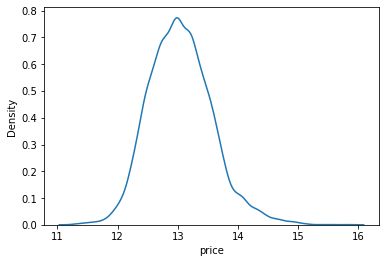

In [20]:
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

확실히 아름다운 정규분포의 모양으로 가까워진 것으로 보입니다!

그러면 여기까지 로그 변환이 필요한 데이터에 대해 처리를 마무리하였으니, 아래와 같이 전체 데이터를 다시 나누어 줍니다.

위에서 저장해두었던 train_len을 인덱스로 활용해서 :train_len까지는 학습 데이터, 즉 x에 저장하고, train_len: 부터는 실제로 추론을 해야 하는 테스트 데이터, 즉 sub 변수에 저장합니다.

In [21]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


# 6-7. 일단 제출하고 시작해! Baseline 모델 (4) 모델 설계

### ✓ 모델링
이제 본격적으로 학습시킬 모델을 준비합니다. Baseline 커널에서는 여러 가지 모델을 함께 사용해서 결과를 섞는, 블렌딩(blending) 이라는 기법을 활용합니다.

블렌딩이란 하나의 개별 모델을 사용하는 것이 아니라 다양한 여러 모델을 종합하여 결과를 얻는 기법입니다.  
블렌딩은 앙상블 기법이라고 하기도 하는데요, 자세한 내용을 다음 포스팅에서 살짝 읽어보겠습니다.

### Q4. 앙상블이란 무엇이고, 어떤 아이디어로부터 착안된 기법인가요?

앙상블(Ensemble) 학습은 여러 개의 학습 알고리즘을 사용하고,  
그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법입니다.  
하나의 강한 머신러닝 알고리즘보다 여러 개의 약한 머신러닝 알고리즘이 낫다는 아이디어로부터 시작되었습니다.

### Q5. 앙상블 기법 중 가장 기본적인 것은 보팅(Voting)과 에버리징(Averaging)입니다. 각각은 무엇이고, 언제 쓰이나요?

이 둘은 모두 서로 다른 알고리즘을 가진 분류기를 결합하는 방식입니다.  
Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다.  
반면, Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용됩니다.

### Q6. 이 둘은 모두 서로 다른 알고리즘을 가진 분류기를 결합하는 방식입니다. Voting은 여러 모델이 분류해 낸 결과들로부터 말 그대로 다수결 투표를 통해 최종 결과를 선택하는 방법으로, 분류 문제에서 사용됩니다. 반면, Averaging은 각 모델이 계산해 낸 실숫값들을 평균 혹은 가중평균하여 사용하는 방법으로, 회귀 문제에서 사용됩니다.

- 다섯 개의 분류기가 전부 다 틀릴 확률은 0.3^5 = 0.0024 입니다.
- 하나의 분류기만 맞고, 네 개의 분류기가 틀릴 확률은 5C_1 × 0.3^4 × 0.7 = 0.0284 입니다.
- 두 개의 분류기만 맞고, 세 개의 분류기가 틀릴 확률은 5C_2 × 0.3^3 × 0.7^2 = 0.1323 입니다.
- 세 개의 분류기만 맞고, 두 개의 분류기가 틀릴 확률은 5C_3 × 0.3^2 × 0.7^3 = 0.3087 입니다.
- 네 개의 분류기가 맞고, 한 개의 분류기가 틀릴 확률은 5C_4 × 0.3 × 0.7^4 = 0.3602 입니다.
- 다섯 개의 분류기가 모두 맞을 확률은 0.7^5 = 0.1681 입니다.
- (확인 : 위의 여섯가지의 확률의 총합은 0.0024 + 0.0284 + 0.1323 + 0.3087 + 0.3602 + 0.1681 = 1 이 맞습니다!)

- 위의 여섯 가지 중, 다수결을 통해 최종 예측을 결정을 할 때 옳은 예측을 하려면 최소 세 개 이상의 분류기가 맞아야 합니다.

- 즉, 세 개 이상의 분류기가 맞을 확률의 총 합은 0.3087 + 0.3602 + 0.1681 =0.837, 즉 83.7%입니다.
- 이는 개별 분류기의 성능인 70%보다 훨씬 높은 성능을 보입니다!

### ✓ Average Blending
여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들겠습니다.

모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용합니다.

In [22]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

print('얍💢')

얍💢


### ✓ Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [24]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score:{CV_score:.4f}")
print('얍💢')

얍💢


In [25]:
get_cv_score(models)

Model: GradientBoosting, CV score:0.8598
Model: XGBoost, CV score:0.8860
Model: LightGBM, CV score:0.8819


### ✓ Make Submission File  
cross_val_score() 함수는 회귀모델을 전달할 경우 R^2 점수를 반환합니다.  
R^2 값은 1에 가까울수록 모델이 잘 학습되었다는 것을 나타냅니다.  
결정계수 R^2 값에 대한 간단한 설명은 아래 링크의 글을 참고하세요.

위의 결과를 보니 3개 트리 모델이 모두 훈련 데이터에 대해 괜찮은 성능을 보여주고 있군요.

Baseline 모델에서는 다음과 같이 여러 모델을 입력하면 각 모델에 대한 예측 결과를 평균 내어 주는 AveragingBlending() 함수를 만들어 사용합니다.  
AveragingBlending() 함수는 models 딕셔너리 안에 있는 모델을 모두 x와 y로 학습시킨 뒤 predictions에 그 예측 결괏값을 모아서 평균한 값을 반환합니다.

In [26]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

print('얍💢')

얍💢


In [27]:
# 함수를 사용해서 예측값을 생성
y_pred = AveragingBlending(models, x, y, sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

In [28]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [29]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [30]:
my_submission_path = join(data_dir, 'submission.csv')
result.to_csv(my_submission_path, index=False)

print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission.csv


# 6-8. 일단 제출하고 시작해! Baseline 모델 (5) 캐글에 첫 결과 제출하기

### Q8. 머신러닝에서 '파라미터' (혹은 모델 파라미터) 와 '하이퍼 파라미터'는 각각 무엇이고, 어떻게 다를까요?

A8. 모델 파라미터는 모델이 학습을 하면서 점차 최적화되는, 그리고 최적화가 되어야 하는 파라미터입니다.  
예를 들어 선형 회귀의 경우 y_pred = W*x + b 라는 식으로 예측값을 만들어 낼 텐데, 여기에서 모델 파라미터는 W 입니다.  
모델은 학습 과정을 거치면서 최적의 y_pred 값, 즉 y_true에 가장 가까운 값을 출력해낼 수 있는 최적의 W를 찾아나갈 것입니다.

반면, 하이퍼 파라미터는 모델이 학습을 하기 위해서 사전에 사람이 직접 입력해 주는 파라미터입니다. 이는 모델이 학습하는 과정에서 변하지 않습니다.
예를 들어 학습 횟수에 해당하는 epoch 수, 가중치를 업데이트할 학습률(learning rate), 또는 선형 규제를 담당하는 labmda 값 등이 이에 해당합니다.

In [31]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('얍💢')

얍💢


In [32]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [33]:
# 위의 date 가 눈에 거슬리기 떄문에 깔끔하게 정리를 해줍니다.

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [34]:
# 타겟 데이터에 해당하는 price 칼럼을 지워줍니다.

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [35]:
# 마지막으로 id 컬럼을 삭제하는 것까지 하면 기본적인 전처리는 모두 마무리됩니다.

del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [36]:
# test에 우리가 맞추어야 할 타겟 데이터인 price는 없으니 훈련 데이터셋과는 다르게 price에 대한 처리는 해주지 않아도 된다는 것을 잊지 마세요!

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [37]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

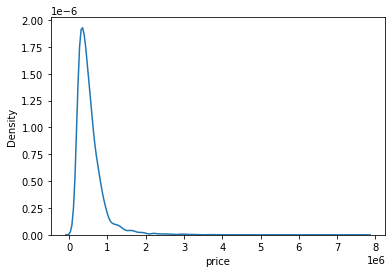

In [38]:
"""
seaborn의 `kdeplot`을 활용해 `y`의 분포를 확인해주세요!
"""

sns.kdeplot(y)
plt.show()

앞서 살펴봤듯이 price는 왼쪽으로 크게 치우쳐 있는 형태를 보입니다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고,

나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌리겠습니다.

np.exp1m()은 np.log1p()과는 반대로 각 원소 x마다 exp(x)-1의 값을 반환해 줍니다.

In [39]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

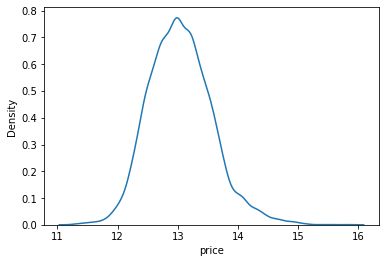

In [40]:
sns.kdeplot(y)
plt.show()

In [41]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 6-10. 랭킹을 올리고 싶다면? (2) 다양한 실험을 위해 함수로 만들어 쓰자

이제부터 본격적으로 모델 튜닝을 해보겠습니다.

머신러닝 모델을 학습시키고 튜닝을 하다 보면 몇 시간이 훌쩍 지났는지 모를 만큼 실험해볼 것들이 많습니다.
보다 다양하고 많은 실험을 하기 위해서는, 그만큼 실험을 위한 도구들이 잘 준비되어 있는 것이 유리하겠죠.

따라서 여러 가지 반복되는 작업들은 함수로 먼저 만들어 놓고 많은 실험을 하는 것이 좋습니다. 이제부터 구현해 보겠습니다.

### RMSE 계산

먼저 필요한 라이브러리를 가져오겠습니다.  
데이터셋을 훈련 데이터셋과 검증 데이터셋으로 나누기 위한 train_test_split 함수와,  
RMSE 점수를 계산하기 위한 mean_squared_error를 가져옵니다.

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('얍💢')

얍💢


대회에서 점수를 매기는 것과 같은 평가 척도인 RMSE를 계산하기 위해 다음과 같은 함수를 만들어놓겠습니다.

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에

원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.

exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!

In [43]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('얍💢')

얍💢


In [44]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델을 가져오겠습니다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('얍💢')

얍💢


In [45]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
# random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('얍💢')

얍💢


In [46]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [47]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [48]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125487.071025
LGBMRegressor,111920.367359
XGBRegressor,110318.669566


# 6-11. 랭킹을 올리고 싶다면? (3) 하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [49]:
from sklearn.model_selection import GridSearchCV

print('얍💢')

얍💢


GridSearchCV란 무엇일까요?

우선 그리드 탐색과 랜덤 탐색을 알아볼 필요가 있습니다. 두 가지 모두 하이퍼 파라미터를 조합해 보는 방법입니다.

그리드 탐색은 사람이 먼저 탐색할 하이퍼 파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색합니다.  
특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리하겠네요!

랜덤 탐색은 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법입니다.

그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있는 반면,  
랜덤 탐색에서는 말 그대로 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 언제나 열려 있습니다.  
하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없어요.  

다음 이미지가 그리드 탐색(grid search)과 랜덤 탐색(random search) 두 가지를 잘 나타내고 있습니다.   
그리드 탐색은 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색하는 반면, 랜덤 탐색은 랜덤으로 점을 찍어서 탐색합니다.

확실히 그리드 탐색의 탐색 공간은 매우 제한적인 반면 랜덤 탐색은 탐색하는 공간이 훨씬 넓습니다.

In [50]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

In [51]:
model = LGBMRegressor(random_state=random_state)

print('얍💢')

얍💢


In [52]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    4.0s finished


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

### Q10. 위에 출력된 메세지에 나타난 totalling 20 fits에서 20은 어떻게 계산된 값일까요?

- 위에서 우리가 입력한 param_grid에 n_estimators 두 가지, max_depth 두 가지를 넣었으므로 가능한 조합은 총 2 × 2 = 4가지입니다.
- 또한, cross validation은 각 경우마다 5번을 진행하니 총 20 fits를 진행하게 됩니다.
- 여기에서 cross validation을 5번 진행하는 이유는, 각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

In [53]:
grid_model.cv_results_

{'mean_fit_time': array([0.20121107, 0.28748732, 0.50799255, 0.7560698 ]),
 'std_fit_time': array([0.05071805, 0.09308523, 0.07944734, 0.0974405 ]),
 'mean_score_time': array([0.00926528, 0.02126398, 0.04171548, 0.04109883]),
 'std_score_time': array([0.00028802, 0.00985865, 0.01745709, 0.01264646]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

In [54]:
params = grid_model.cv_results_['params']
params

[{'max_depth': 1, 'n_estimators': 50},
 {'max_depth': 1, 'n_estimators': 100},
 {'max_depth': 10, 'n_estimators': 50},
 {'max_depth': 10, 'n_estimators': 100}]

In [55]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.07339447, -0.05502043, -0.02917734, -0.02702714])

params에는 각 파라미터의 조합이, score에는 각 조합에 대한 점수가 들어가 있군요.

이제 이 둘만 가지고 데이터 프레임을 만들고 최적의 성능을 내는 하이퍼 파라미터의 조합을 찾아봅시다.

다음과 같은 형태의 데이터 프레임을 출력하는 코드를 작성해 보세요.

In [56]:
results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


### Q11. GridSearchCV에서 모델을 초기화할 때 scoring 인자에는 무엇을 넣었나요?

MSE에 음수를 취한 값인 neg_mean_squared_error를 입력했습니다.

### Q12. 위의 페이지에서는 각 점수(scoring)를 세 가지로 분류해놓고 있다. 세 분류 범주는 무엇인가?

Classification, Clustering, Regression이다. 어떤 문제를 푸느냐에 따라 각 상황에 알맞은 점수 체계를 사용할 수 있다.

우리는 Regression 문제를 풀고 있기 때문에 그에 알맞은 성능 평가 지표를 사용하였습니다.  
neg_mean_squared_error를 사용했기 때문에 점수가 음수로 표현되는 것이죠!

아래와 같은 간단한 변환 함수로 RMSE 점수를 볼 수 있도록 하겠습니다.  
음수로 된 MSE였으니, -1을 곱해주고 np.sqrt로 루트 연산을 해주면 되겠죠.

In [57]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


하지만 아직도 위에서 보았던 10만 단위의 RMSE와는 값의 크기가 아주 다른 것 같습니다.

그 이유는 price에 있습니다. 위에서 우리는 price의 분포가 한쪽으로 치우쳐져 있는 것을 보고 log 변환을 했었죠.  
그 후 RMSE 값을 계산하기 위한 함수에서는 np.expm1 함수를 활용해 다시 원래대로 복원한 후 RMSE 값을 계산했습니다.

하지만 그리드 탐색을 하면서는 np.expm1()으로 변환하는 과정이 없었기 때문에 log 변환되어 있는 price 데이터에서 손실함수값을 계산한 것이죠.  
따라서 사실, 위의 데이터 프레임에 나타난 값은 정확히 말하면 RMSE가 아니라 RMSLE, 즉 Root Mean Squared Log Error 입니다.  
log를 취한 값에서 RMSE를 구했다는 뜻이죠!

이에 맞게 컬럼의 이름을 RMSLE로 변환해 주도록 하겠습니다. 판다스에서 컬럼의 이름 변환은 rename으로 할 수 있습니다.

In [58]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [59]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [60]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# 6-12. 랭킹을 올리고 싶다면? (4) 제출하는 것도, 빠르고 깔끔하게!

이제 실험에 대한 준비는 모두 끝났습니다! 실험을 통해 좋은 결과를 내는 모델을 찾았다면 제출을 해봐야겠죠.  
제출 과정 또한 하나의 함수로 깔끔하게 진행하겠습니다.

먼저 위에서 만들어놓은 my_GridSearch() 함수로 간단한 그리드 탐색을 해보겠습니다.

In [61]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    2.1s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


가장 좋은 조합은 max_depth=10, n_estimators=100 이군요.  
해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

먼저 해당 파라미터로 구성된 모델을 준비하고, 학습 후 예측 결과를 생성합니다.

In [62]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [63]:
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [64]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [65]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [66]:
# 위의 데이터를 csv 파일로 저장
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.164399.csv


In [67]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [68]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!
